In [1]:
import requests
import lxml.html as lh
import pandas as pd
import re

In [2]:
#This code is inspired in https://towardsdatascience.com/web-scraping-html-tables-with-python-c9baba21059
def parse_url(url, date):
    #Create a handle, page, to handle the contents of the website
    page = requests.get(url)

    #Store the contents of the website under doc
    doc = lh.fromstring(page.content)

    #Parse data that are stored between <tr>..</tr> of HTML
    #tr_elements = doc.xpath('//tr')
    tr_elements = doc.xpath('/html/body/div[1]/div[4]/div[1]/div/div[3]/table/tbody/tr')
        
    
    #Create empty list
    col=[]
    i=0#For each row, store each first element (header) and an empty list
    for t in tr_elements[0]:
        i+=1
        name=t.text_content().strip()
        #print ("column:", i, name)
        col.append((name,[]))
        
    #Append the date column   
    col.append(("Fecha", []))
        
    #Since out first row is the header, data is stored on the second row onwards
    for j in range(1,len(tr_elements)):
        #print ("row:", j)
        
        #T is our j'th row
        T=tr_elements[j]
        #print ("row:", T)

        #If row is not of size 10, the //tr data is not from our table 
        if len(T)!=2:
            break

        #i is the index of our column
        i=0

        #Iterate through each element of the row
        for t in T.iterchildren():
            #print("i:", i, "j:", j, "cell:", t)
            data=t.text_content().strip() 
            #print("i:", i, "j:", j, "data:", data)
            #Check if row is empty
            if i>0:
            #Convert any numerical value to integers
                try:
                    data=int(data)                    
                except:
                    pass
            #Append the data to the empty list of the i'th column
            #print (data)
            col[i][1].append(data)
            #Increment i for the next column
            i+=1    
            
        #Append the date column   
        col[i][1].append(date)
            
    #print("col:", col)        
    
    Dict={title:column for (title,column) in col}    
    df=pd.DataFrame(Dict)
    #df.head()
    
    return df


In [3]:
!pip install PyPDF2
def parse_pdf_url_debug(url, date, debug = False):
    import PyPDF2

    response = requests.get(url)
    my_raw_data = response.content

    with open("my_pdf.pdf", 'wb') as my_data:
        my_data.write(my_raw_data)

    page_content = ""
        
    read_pdf = PyPDF2.PdfFileReader("my_pdf.pdf")
    number_of_pages = read_pdf.getNumPages()
    if debug:
        print("number_of_pages: ", number_of_pages)
    for page_number in range(number_of_pages):   # use xrange in Py2
            page = read_pdf.getPage(page_number)            
#             if debug:
#                 print("page: " + page)
               
            page_text = page.extractText()
            if debug:
                print("page_text: " + page_text)
                
            page_content = page_content + page_text

    if debug:
        print("::::::::::::::::::page_content::::::::::::::::::") 
        type(page_content)
            
    page_content = clean_pdf_content(page_content, debug)        
            
    page_content_split = page_content.split('\n \n')
    type(page_content_split)
        
    page_content_split_filtered = list(filter(lambda x: "nosticados" not in x and "notificados" not in x and "Zona Básica" not in x and x != "Casos" and x != " " and x != "" and x != " \n" and not "/2020" in x, page_content_split))
    #remove trailing new lines
    page_content_split_filtered = list(map(lambda x: x.strip("\n"), page_content_split_filtered))
    if debug:
        print("::::::::::::::::::page_content_split_filtered::::::::::::::::::")
        print(page_content_split_filtered)

    elements = int((len(page_content_split_filtered))/2)
    #print(elements)
    type(elements)

    import  numpy as np
    reshaped_array = np.reshape(np.array(page_content_split_filtered), (elements, 2))

    a_dataframe = pd.DataFrame(reshaped_array, columns=["Zona Básica", "Casos"])
    a_dataframe = a_dataframe.astype({'Casos': 'int32'})

    a_dataframe = a_dataframe.assign(Fecha=[date]*elements)
    
    return a_dataframe

def clean_pdf_content(page_content, debug):    
        
    page_content = page_content.replace("1\n \n \nCasos\n \nnotificados", "Casos notificados") 
    page_content = page_content.replace("1\n \n \nCasos \nnotificados", "Casos notificados") 

    page_content = page_content.replace("Zona \nBásica" , "Zona Básica")
    page_content = page_content.replace("Zona B\ná\nsica" , "Zona Básica")
            
        
    page_content = page_content.replace("\nÑ\n", "Ñ")  
    page_content = page_content.replace("TORRERO\n \nLA PAZ", "TORRERO LA PAZ")
    page_content = page_content.replace("AVENIDA \nCATALUÑA", "AVENIDA CATALUÑA")
    page_content = page_content.replace("BIESCAS\n-\nVALLE DE TENA", "BIESCAS-VALLE DE TENA ")
    page_content = page_content.replace("SANTA \nEULALIA DEL CAMPO", "SANTA EULALIA DEL CAMPO")
    page_content = page_content.replace("VALDESPARTERA\n-\nMONTECANAL", "VALDESPARTERA-MONTECANAL")
    page_content = page_content.replace("SAGASTA\n-\nRUISEÑORES", "SAGASTA-RUISEÑORES")
    page_content = page_content.replace("HUESCA CAPITAL -1 \n(PERPETUO SOCORRO", "HUESCA CAPITAL Nº 1 (PERPETUO SOCORRO)")
    page_content = page_content.replace("HUESCA CAPITAL Nº 1 \n(PERPETUO SOCORRO", "HUESCA CAPITAL Nº 1 (PERPETUO SOCORRO)")
    page_content = page_content.replace("HUESCA CAPITAL N\nº\n \n1 (PERPETUO SOCORRO)", "HUESCA CAPITAL Nº 1 (PERPETUO SOCORRO)")
    page_content = page_content.replace("HUESCA CAPITAL Nº 2 (SANTO \nGRIAL)", "HUESCA CAPITAL Nº 2 (SANTO GRIAL)")
    page_content = page_content.replace("HUESCA CAPITAL Nº \n2 (SANTO GRIAL)", "HUESCA CAPITAL Nº 2 (SANTO GRIAL)")
    page_content = page_content.replace("HUESCA CAPITAL N\nº\n \n2 (SANTO GRIAL)", "HUESCA CAPITAL Nº 2 (SANTO GRIAL)")
    page_content = page_content.replace("MADRE \nVEDRUNA\n-\nMIRAFLORES", "MADRE VEDRUNA-MIRAFLORES")
    page_content = page_content.replace("MADRE VEDRUNA\n-\nMIRAFLORES", "MADRE VEDRUNA-MIRAFLORES") 
    page_content = page_content.replace("FERNANDO EL\n \nCATOLICO", "FERNANDO EL CATOLICO")    
    page_content = page_content.replace("SAN JOSE\n \nNORTE", "SAN JOSE NORTE")    
    page_content = page_content.replace("CAMPO DE\n \nBELCHITE", "CAMPO DE BELCHITE")
    page_content = page_content.replace("ALAGON", "ALAGÓN")
    
    page_content = page_content.replace("\n-\n \n", "-")
    page_content = page_content.replace("Nº\n \n", "-")
        
    page_content = re.sub(r'(\d+)\n \n\d+', r'\1', page_content)
    
    if debug:
        print("::::::::::::::::::page_content_filtered::::::::::::::::::")
        print(page_content)
        
    return page_content


def parse_pdf_url(url, date):
    return parse_pdf_url_debug(url, date, debug = False)


     |████████████████████████████████| 81kB 7.2MB/s eta 0:00:011
  Stored in directory: /home/dsxuser/.cache/pip/wheels/53/84/19/35bc977c8bf5f0c23a8a011aa958acd4da4bbd7a229315c1b7
Successfully built PyPDF2


In [4]:
def parse_excel(url, sheet, date, skiprows=26):
    xls = pd.ExcelFile(url)
    df = xls.parse(sheet, skiprows=skiprows, usecols="A:B", na_values=['NA']) 
    df['Zona Básica'] = df['Zona Básica'].str.upper()
    df['Fecha']=date
    return df

#df = parse_excel('https://transparencia.aragon.es/sites/default/files/documents/20200822_casos_confirmados_zbs.xlsx.xlsx', "20200822", "2020-08-22")
#df

In [5]:
#Scrap the HTML as data frames
frames = [parse_url("http://www.aragonhoy.net/index.php/mod.noticias/mem.detalle/relmenu.9/id.263522", "2020-07-21"), 
          parse_url("http://www.aragonhoy.net/index.php/mod.noticias/mem.detalle/relmenu.9/id.263587", "2020-07-22"),
          parse_pdf_url("http://www.aragonhoy.net/index.php/mod.documentos/mem.descargar/fichero.documentos_zonas_de_salud_240720_b207d97a%232E%23pdf", "2020-07-23"),
          parse_pdf_url("http://www.aragonhoy.net/index.php/mod.documentos/mem.descargar/fichero.documentos_Casos_diagnosticados_el_24_21d693c5%232E%23pdf", "2020-07-24"),
          parse_pdf_url("http://www.aragonhoy.net/index.php/mod.documentos/mem.descargar/fichero.documentos_Casos_diagnosticados_a_25_f6c24e2b%232E%23pdf", "2020-07-25"),              
          parse_pdf_url("http://www.aragonhoy.net/index.php/mod.documentos/mem.descargar/fichero.documentos_Casos_notificados_el_27_f174cec5%232E%23pdf", "2020-07-26"),
          parse_pdf_url("http://www.aragonhoy.net/index.php/mod.documentos/mem.descargar/fichero.documentos_Casos_notificados_el_28_502913f8%232E%23pdf", "2020-07-27"),
          parse_pdf_url("http://www.aragonhoy.net/index.php/mod.documentos/mem.descargar/fichero.documentos_Casos_notificados_el_29_8534c52d%232E%23pdf", "2020-07-28"),
          parse_pdf_url("http://www.aragonhoy.net/index.php/mod.documentos/mem.descargar/fichero.documentos_Casos_notificados_a_30_11f0e64d%232E%23pdf", "2020-07-29"),
          parse_pdf_url("http://www.aragonhoy.net/index.php/mod.documentos/mem.descargar/fichero.documentos_Casos_notificados_a_31_de_julio_dde77bb3%232E%23pdf", "2020-07-30"),
          parse_pdf_url("http://www.aragonhoy.net/index.php/mod.documentos/mem.descargar/fichero.documentos_Casos_notificados_a_1_de_agosto_ba3703f6%232E%23pdf", "2020-07-31"),
          #no data for "2020-08-01"
          parse_pdf_url("http://www.aragonhoy.net/index.php/mod.documentos/mem.descargar/fichero.documentos_Casos_notificados_a_3_de_agosto_52586f10%232E%23pdf", "2020-08-02"),
          parse_pdf_url("http://www.aragonhoy.net/index.php/mod.documentos/mem.descargar/fichero.documentos_Casos_notificados_el_4_de_agosto_d36b8d68%232E%23pdf", "2020-08-03"),
          parse_pdf_url("http://www.aragonhoy.net/index.php/mod.documentos/mem.descargar/fichero.documentos_Casos_notificados_el_5_4e43cbfd%232E%23pdf", "2020-08-04"),
          parse_pdf_url("http://www.aragonhoy.net/index.php/mod.documentos/mem.descargar/fichero.documentos_Casos_notificados_el_6_fcab7d34%232E%23pdf", "2020-08-05"),
          parse_pdf_url("http://www.aragonhoy.net/index.php/mod.documentos/mem.descargar/fichero.documentos_Casos_notificados_el_7_89a1d565%232E%23pdf", "2020-08-06"),
          parse_pdf_url("http://www.aragonhoy.net/index.php/mod.documentos/mem.descargar/fichero.documentos_Casos_notificados_el_8_de_agosto_ec5ef6dd%232E%23pdf", "2020-08-07"),
          parse_pdf_url("http://www.aragonhoy.net/index.php/mod.documentos/mem.descargar/fichero.documentos_Casos_notificados_el_9_934914e7%232E%23pdf", "2020-08-08"),
          parse_pdf_url("http://www.aragonhoy.net/index.php/mod.documentos/mem.descargar/fichero.documentos_Casos_notificados_el_10_de_agosto_7f2d05d5%232E%23pdf", "2020-08-09"),
          parse_pdf_url("http://www.aragonhoy.net/index.php/mod.documentos/mem.descargar/fichero.documentos_Casos_notificados_el_13_de_agosto_f1e9a29a%232E%23pdf", "2020-08-12"),
          #excel
          parse_excel("https://transparencia.aragon.es/sites/default/files/documents/20200813_casos_confirmados_zbs.xlsx", "20200813", "2020-08-13", skiprows=12),
          parse_excel("https://transparencia.aragon.es/sites/default/files/documents/20200814_casos_confirmados_zbs.xlsx", "20200814", "2020-08-14"),
          parse_excel("https://transparencia.aragon.es/sites/default/files/documents/20200815_casos_confirmados_zbs.xlsx", "20200815", "2020-08-15"),
          parse_excel("https://transparencia.aragon.es/sites/default/files/documents/20200816_casos_confirmados_zbs.xlsx", "20200816", "2020-08-16"),
          parse_excel("https://transparencia.aragon.es/sites/default/files/documents/20200817_casos_confirmados_zbs.xlsx", "20200817", "2020-08-17"),
          parse_excel("https://transparencia.aragon.es/sites/default/files/documents/20200818_casos_confirmados_zbs.xlsx", "20200818", "2020-08-18"),
          parse_excel("https://transparencia.aragon.es/sites/default/files/documents/20200819_casos_confirmados_zbs.xlsx", "20200819", "2020-08-19"),
          parse_excel("https://transparencia.aragon.es/sites/default/files/documents/20200820_casos_confirmados_zbs.xlsx", "20200815", "2020-08-20", skiprows=12), #The tab name was wrong in the Excel file
          parse_excel("https://transparencia.aragon.es/sites/default/files/documents/20200821_casos_confirmados_zbs.xlsx", "20200821", "2020-08-21"),
          parse_excel("https://transparencia.aragon.es/sites/default/files/documents/20200822_casos_confirmados_zbs.xlsx.xlsx", "20200822", "2020-08-22"),
          parse_excel("https://transparencia.aragon.es/sites/default/files/documents/20200823_casos_confirmados_zbs.xlsx", "20200823", "2020-08-23"),
          parse_excel("https://transparencia.aragon.es/sites/default/files/documents/20200824_casos_confirmados_zbs.xlsx", "20200824", "2020-08-24"),
          parse_excel("https://transparencia.aragon.es/sites/default/files/documents/20200825_casos_confirmados_zbs.xlsx", "20200826", "2020-08-25"),
          parse_excel("https://transparencia.aragon.es/sites/default/files/documents/20200826_casos_confirmados_zbs.xlsx", "20200826", "2020-08-26"),
          parse_excel("https://transparencia.aragon.es/sites/default/files/documents/20200827_casos_confirmados_zbs.xlsx", "20200827", "2020-08-27"),
          parse_excel("https://transparencia.aragon.es/sites/default/files/documents/20200828_casos_confirmados_zbs.xlsx", "20200828", "2020-08-28"),
          parse_excel("https://transparencia.aragon.es/sites/default/files/documents/20200829_casos_confirmados_zbs.xlsx", "20200829", "2020-08-29"),
          parse_excel("https://transparencia.aragon.es/sites/default/files/documents/20200830_casos_confirmados_zbs.xlsx", "20200830", "2020-08-30"),
          parse_excel("https://transparencia.aragon.es/sites/default/files/documents/20200831_casos_confirmados_zbs.xlsx", "20200831", "2020-08-31"),
          parse_excel("https://transparencia.aragon.es/sites/default/files/documents/20200901_casos_confirmados_zbs.xlsx", "20200901", "2020-09-01"),
          parse_excel("https://transparencia.aragon.es/sites/default/files/documents/20200902_casos_confirmados_zbs.xlsx", "20200902", "2020-09-02")
         ]

#Concatenate the data frames
result = pd.concat(frames)

#Pivot the table
table = pd.pivot_table(result, values='Casos', index=['Zona Básica'],
                    columns=['Fecha'], fill_value=0)

#print(table)
    

In [6]:
#Delete the TOTAL row, because we do not have total every day
table = table[table.index != "TOTAL"]
#Create the TOTAL row again
table = table.append(table.sum().rename('TOTAL'))

#Create the TOTAL column
# total_column = table["2020-07-21"] + table["2020-07-22"] + table["2020-07-23"] + table["2020-07-24"] + table["2020-07-25"] + table["2020-07-26"] + table["2020-07-27"] + table["2020-07-28"] + table["2020-07-29"] \
#          + table["2020-07-30"] + table["2020-07-31"] + table["2020-08-02"] + table["2020-08-03"] + table["2020-08-04"]
# table["TOTAL"] = total_column

table["TOTAL"] = table[list(table.columns)].sum(axis=1)

#10 health districts with most cases
top_10 = table[table.index != "TOTAL"].sort_values(by=['TOTAL'], ascending=False).head(10)


In [7]:
#transpose the top 10
top_10_t = top_10.transpose()

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(11, 4)})

top_10_t[top_10_t.index != "TOTAL"].plot(stacked=True).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

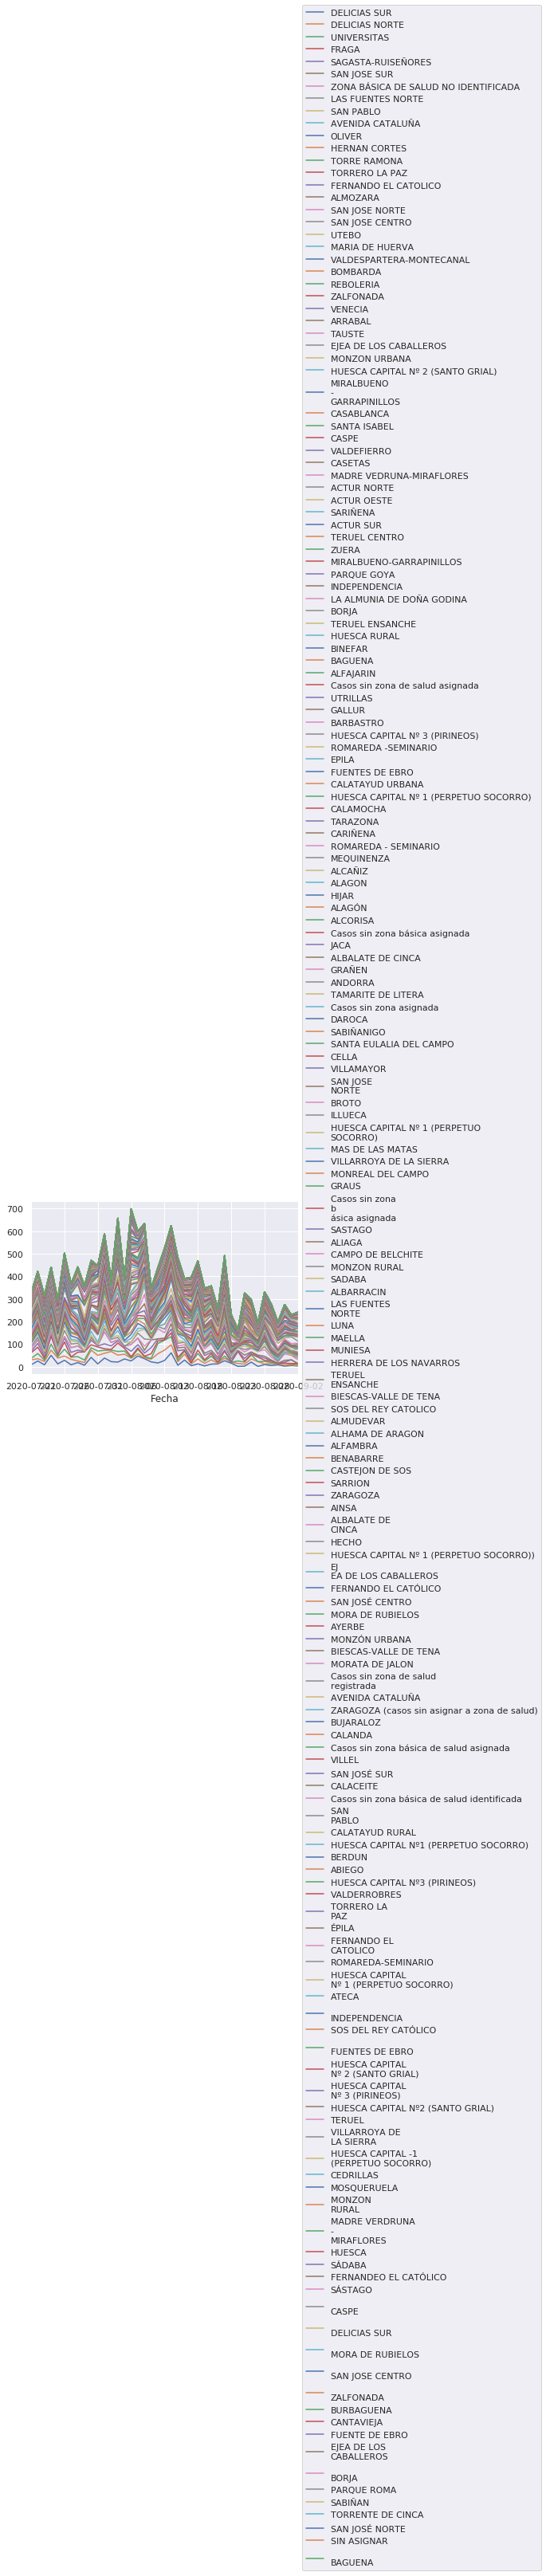

In [9]:
table_no_total = table[table.index != "TOTAL"].sort_values(by=['TOTAL'], ascending=False)
table_no_total_t =  table_no_total.transpose()

table_no_total_t[table_no_total_t.index != "TOTAL"].plot(stacked=True).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

In [10]:
table[table.index != "TOTAL"].sort_values(by=['TOTAL'], ascending=False).head(20)

Fecha,2020-07-21,2020-07-22,2020-07-23,2020-07-24,2020-07-25,2020-07-26,2020-07-27,2020-07-28,2020-07-29,2020-07-30,...,2020-08-25,2020-08-26,2020-08-27,2020-08-28,2020-08-29,2020-08-30,2020-08-31,2020-09-01,2020-09-02,TOTAL
Zona Básica,,,,,,,,,,,,,,,,,,,,,
DELICIAS SUR,8.0,25.0,8.0,50.0,12.0,28.0,8.0,18.0,6.0,41.0,...,2.0,20.0,1.0,9.0,5.0,8.0,2.0,5.0,3.0,736.0
DELICIAS NORTE,22.0,10.0,15.0,23.0,26.0,19.0,24.0,7.0,12.0,32.0,...,9.0,14.0,21.0,3.0,8.0,4.0,4.0,3.0,0.0,706.0
UNIVERSITAS,6.0,23.0,6.0,27.0,6.0,30.0,10.0,19.0,11.0,10.0,...,9.0,18.0,0.0,11.0,5.0,2.0,9.0,4.0,6.0,537.5
FRAGA,25.0,28.0,8.0,35.0,8.0,32.0,1.0,20.0,36.0,14.0,...,3.0,4.0,20.0,5.0,6.0,0.0,0.0,2.0,4.0,501.0
SAGASTA-RUISEÑORES,6.0,17.0,9.0,12.0,5.0,18.0,20.0,9.0,2.0,20.0,...,13.0,8.0,4.0,10.0,3.0,1.0,5.0,16.0,0.0,474.0
SAN JOSE SUR,12.0,15.0,9.0,8.0,9.0,6.0,21.0,18.0,1.0,11.0,...,15.0,1.0,5.0,8.0,2.0,0.0,8.0,0.0,1.0,457.5
ZONA BÁSICA DE SALUD NO IDENTIFICADA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,14.0,17.0,16.0,29.0,13.0,7.0,28.0,20.0,16.0,404.0
LAS FUENTES NORTE,11.0,11.0,5.0,19.0,7.0,27.0,16.0,12.0,1.0,2.0,...,11.0,0.0,0.0,13.0,11.0,2.0,7.0,3.0,9.0,383.0
SAN PABLO,11.0,11.0,7.0,15.0,1.0,21.0,14.0,6.0,2.0,9.0,...,14.0,2.0,0.0,10.0,4.0,7.0,3.0,0.0,8.0,348.0


In [19]:
table_no_total_row_no_col_t = table_no_total_t.drop('TOTAL')
table_no_total_row_no_col_t['ARRABAL'].plot().legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

KeyError: "['TOTAL'] not found in axis"